Shape of dataset: (93597, 11)
   work_year experience_level employment_type           job_title  salary  \
0       2025               MI              FT  Research Scientist  208000   
1       2025               MI              FT  Research Scientist  147000   
2       2025               SE              FT  Research Scientist  173000   
3       2025               SE              FT  Research Scientist  117000   
4       2025               MI              FT         AI Engineer  100000   

  salary_currency  salary_in_usd employee_residence  remote_ratio  \
0             USD         208000                 US             0   
1             USD         147000                 US             0   
2             USD         173000                 US             0   
3             USD         117000                 US             0   
4             USD         100000                 US           100   

  company_location company_size  
0               US            M  
1               US      

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.109e+13, tolerance: 2.273e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.433e+13, tolerance: 2.273e+10
  model = cd_fast.enet_coordinate_descent(



🔹 Model Results After Reducing Category Explosion:
                 R2        MAE       RMSE
Ridge         0.275  45463.790  57648.287
Lasso         0.275  45464.162  57648.702
ElasticNet    0.275  45472.826  57657.305
RandomForest  0.289  44824.391  57089.646
XGBoost       0.289  44799.172  57081.015


/tmp/ipython-input-3214527285.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.reset_index(), x='index', y='R2', palette='crest')


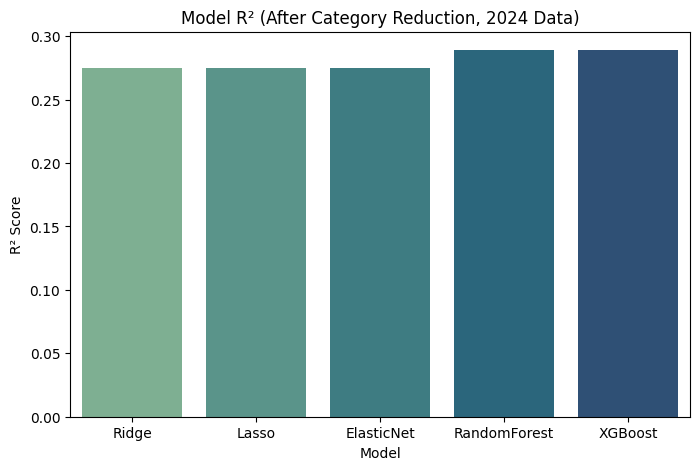

/tmp/ipython-input-3214527285.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.reset_index(), x='index', y='RMSE', palette='flare')


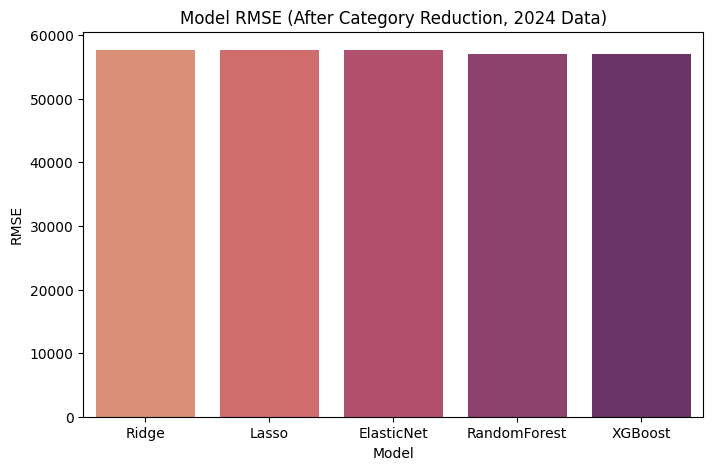


✅ Best performing model (after category reduction): RandomForest


In [1]:
#category explosion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df = pd.read_csv("DataScience_salaries_2025.csv")

print("Shape of dataset:", df.shape)
print(df.head())
print(df.info())

df.rename(columns={
    'work_year': 'year',
    'experience_level': 'seniority_level',
    'employment_type': 'status'
}, inplace=True)

df['work_setting'] = df['remote_ratio'].map({
    0: 'On-site',
    50: 'Hybrid',
    100: 'Remote'
})

# Clean categorical columns
for col in ['job_title', 'seniority_level', 'status',
            'employee_residence', 'company_location', 'company_size']:
    df[col] = df[col].astype(str).str.strip().str.title()

# Remove extreme salary outliers
df = df[df['salary_in_usd'] < 400000]
print("Data after cleaning:", df.shape)

#year 2024
df_2024 = df[df['year'] == 2024].copy()
print("Subset for 2024:", df_2024.shape)

#reducing categories
def reduce_categories(series, top_n=20):
    """Keep only top_n frequent categories, others grouped as 'Other'."""
    top = series.value_counts().nlargest(top_n).index
    return series.where(series.isin(top), 'Other')

# Apply to high-cardinality columns
for col, top_n in {
    'job_title': 20,
    'employee_residence': 15,
    'company_location': 15
}.items():
    df_2024[col] = reduce_categories(df_2024[col], top_n)

print("Unique values after grouping:")
print({col: df_2024[col].nunique() for col in ['job_title', 'employee_residence', 'company_location']})


X = df_2024[['seniority_level', 'status', 'job_title',
             'company_size', 'work_setting', 'employee_residence']]
y = df_2024['salary_in_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0], "| Test samples:", X_test.shape[0])

categorical_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42)
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }

results_df = pd.DataFrame(results).T.round(3)
print("\n🔹 Model Results After Reducing Category Explosion:")
print(results_df)

# Bar Plot – Model R²
plt.figure(figsize=(8,5))
sns.barplot(data=results_df.reset_index(), x='index', y='R2', palette='crest')
plt.title('Model R² (After Category Reduction, 2024 Data)')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.show()

# Bar Plot – Model RMSE
plt.figure(figsize=(8,5))
sns.barplot(data=results_df.reset_index(), x='index', y='RMSE', palette='flare')
plt.title('Model RMSE (After Category Reduction, 2024 Data)')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

best_model = results_df['R2'].idxmax()
print(f"\n✅ Best performing model (after category reduction): {best_model}")
